In [1]:
from sklearn.metrics import accuracy_score
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import MaxPooling2D
from keras.layers import Flatten
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# Data preparation

## Load Data

In [2]:
# Load the data
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

In [3]:
y_train = train['label']

# drop label column
X_train = train.drop(['label'],axis=1)

del train

## Normalization 

In [4]:
# Normalize the data
X_train = X_train/255.0
test = test/255.0

## Reshape

In [5]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## Split train and validation set 

In [6]:
# split the data
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=42)

# CNN

## Define The Model 

In [7]:
# set the CNN model
classifier = Sequential()

classifier.add(Conv2D(6,(5,5), input_shape = (28,28,1),activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Conv2D(16,(5,5),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Flatten())
classifier.add(Dense(units=120,activation='relu'))

classifier.add(Dense(units=84,activation='relu'))

classifier.add(Dense(units=10,activation='softmax'))

classifier.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

## Data Augmentation 

In [8]:
# data augmentation
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.1,
                             zoom_range=0.1,
                             height_shift_range=0.1)
datagen.fit(X_train)

In [9]:
# fit the model
history = classifier.fit(datagen.flow(X_train,y_train,batch_size=128),
                         epochs=100,
                         steps_per_epoch = X_train.shape[0]//128, 
                         validation_data=(X_val,y_val),
                         verbose=2)

Epoch 1/100
 - 17s - loss: 0.7212 - accuracy: 0.7693 - val_loss: 0.1831 - val_accuracy: 0.9424
Epoch 2/100
 - 12s - loss: 0.2348 - accuracy: 0.9282 - val_loss: 0.1085 - val_accuracy: 0.9671
Epoch 3/100
 - 12s - loss: 0.1801 - accuracy: 0.9442 - val_loss: 0.0983 - val_accuracy: 0.9710
Epoch 4/100
 - 13s - loss: 0.1487 - accuracy: 0.9547 - val_loss: 0.0878 - val_accuracy: 0.9721
Epoch 5/100
 - 12s - loss: 0.1278 - accuracy: 0.9617 - val_loss: 0.0736 - val_accuracy: 0.9788
Epoch 6/100
 - 13s - loss: 0.1217 - accuracy: 0.9629 - val_loss: 0.0636 - val_accuracy: 0.9807
Epoch 7/100
 - 12s - loss: 0.1016 - accuracy: 0.9677 - val_loss: 0.0669 - val_accuracy: 0.9793
Epoch 8/100
 - 12s - loss: 0.0982 - accuracy: 0.9697 - val_loss: 0.0600 - val_accuracy: 0.9793
Epoch 9/100
 - 13s - loss: 0.0883 - accuracy: 0.9725 - val_loss: 0.0512 - val_accuracy: 0.9845
Epoch 10/100
 - 13s - loss: 0.0863 - accuracy: 0.9740 - val_loss: 0.0537 - val_accuracy: 0.9833
Epoch 11/100
 - 14s - loss: 0.0788 - accuracy: 0.

In [10]:
model_json = classifier.to_json()
with open("./model_in_json.json","w") as json_file:
    json.dump(model_json, json_file)
    
#  save model
classifier.save_weights("./model.h5")

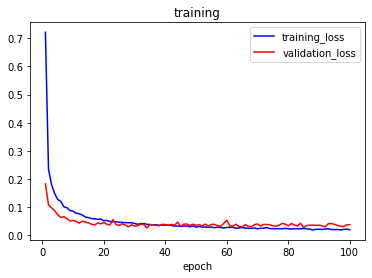

In [11]:
# Drawing plots
import matplotlib.pyplot as plt

epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.savefig("./loss.jpg", bbox_inches='tight')

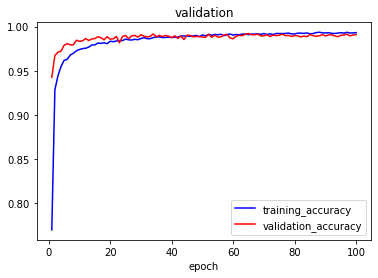

In [12]:
plt.plot(epochs, history.history['accuracy'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_accuracy'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')
plt.savefig("./acc.jpg", bbox_inches='tight')

In [13]:
# submission
pred = classifier.predict(test)

y_pred = []
for i in pred:
    y_pred.append(i.tolist().index(i.max()))
    
dict = {'ImageId':[],'Label':[]}

for id, label in zip(range(1,pred.shape[0]+1),y_pred):
    dict.setdefault('ImageId',[]).append(id)
    dict.setdefault('Label',[]).append(label)

submission = pd.DataFrame(dict)
submission.to_csv("Submission.csv",index=False)